Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [211]:
import numpy as np
from numpy.typing import NDArray
from icecream import ic

from tqdm.auto import tqdm
from itertools import accumulate
from matplotlib import pyplot as plt

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [212]:
UNIVERSE_SIZE = 1_000
NUM_SETS = 200

DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(NUM_SETS * DENSITY)]))

In [213]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [214]:
def valid(solution) -> np.bool:
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution)-> np.float64:
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [215]:
def fitness(
    solution: NDArray[np.bool],
    penalty: dict[str, float] = {
        "redundancy": 1.5,
        "set_count": 10.0,
    },
) -> np.float64:
    # Calculate how often each element in the universe is covered
    element_coverage: NDArray[np.int16] = SETS[solution].sum(axis=0)

    # Penalize for redundant coverage: penalize elements covered more than once
    redundancy_penalty = np.sum((element_coverage[element_coverage > 1]) ** penalty["redundancy"])

    # Calculate the penalty based on the number of sets used
    num_sets_used = solution.sum()  # Count the number of sets included in the solution
    set_count_penalty = num_sets_used * penalty["set_count"]  # Apply penalty based on the count of sets

    # Calculate the fitness value
    if valid(solution):
        return -cost(solution) - redundancy_penalty - set_count_penalty
    else:
        return np.float64(-np.inf)


def mutate(
    solution: NDArray[np.bool],
    penalty: dict[str, float] = {
        "redundancy": 1.5,
        "set_count": 10.0,
    },
) -> NDArray[np.bool]:
    # Create a matrix where each row is the solution with one set flipped
    flip_matrix = np.tile(solution, (NUM_SETS, 1))  # Duplicate the solution NUM_SETS times
    flip_matrix[np.arange(NUM_SETS), np.arange(NUM_SETS)] ^= True  # Flip each set once

    # Compute fitness for all flipped solutions in a vectorized manner
    fitness_values = np.apply_along_axis(lambda sol: fitness(sol, penalty), 1, flip_matrix)

    # Find the flip that gives the maximum fitness value (reduction)
    best_flip_index = np.argmax(fitness_values)

    # Apply the best flip to the solution
    best_solution = flip_matrix[best_flip_index]

    return best_solution

In [216]:
def fit(
    solution: NDArray[np.bool],
    steps: int = 200,
    penalty: dict[str, float] = {
        "redundancy": 1.5,
        "set_count": 10.0,
    },
    plot: bool = False,
) -> NDArray[np.bool]:
    history: list[np.float64] = [fitness(solution)]
    new_solution: NDArray[np.bool] = mutate(solution, penalty)
    history.append(fitness(new_solution))
    # Copied from here
    # https://github.com/squillero/computational-intelligence/blob/master/2024-25/multiple-knapsack.ipynb
    for _ in tqdm(range(steps)):
        new_solution = mutate(new_solution, penalty)
        history.append(fitness(new_solution))

    if plot:
        plt.figure(figsize=(14, 8))
        plt.plot(
            range(len(history)),
            list(accumulate(history, max)),  # type: ignore
            color="red",
        )
        plt.scatter(range(len(history)), history, marker=".")
    return new_solution

ic| fitness(random_solution): np.float64(-197187.77124873165)
    cost(random_solution): np.float64(49031.95744184537)
    valid(random_solution): np.True_


  0%|          | 0/100 [00:00<?, ?it/s]

ic| fitness(solution): np.float64(-14003.70120891753)
    cost(solution): np.float64(6463.0598252206155)
    valid(solution): np.True_


(np.float64(-14003.70120891753), np.float64(6463.0598252206155), np.True_)

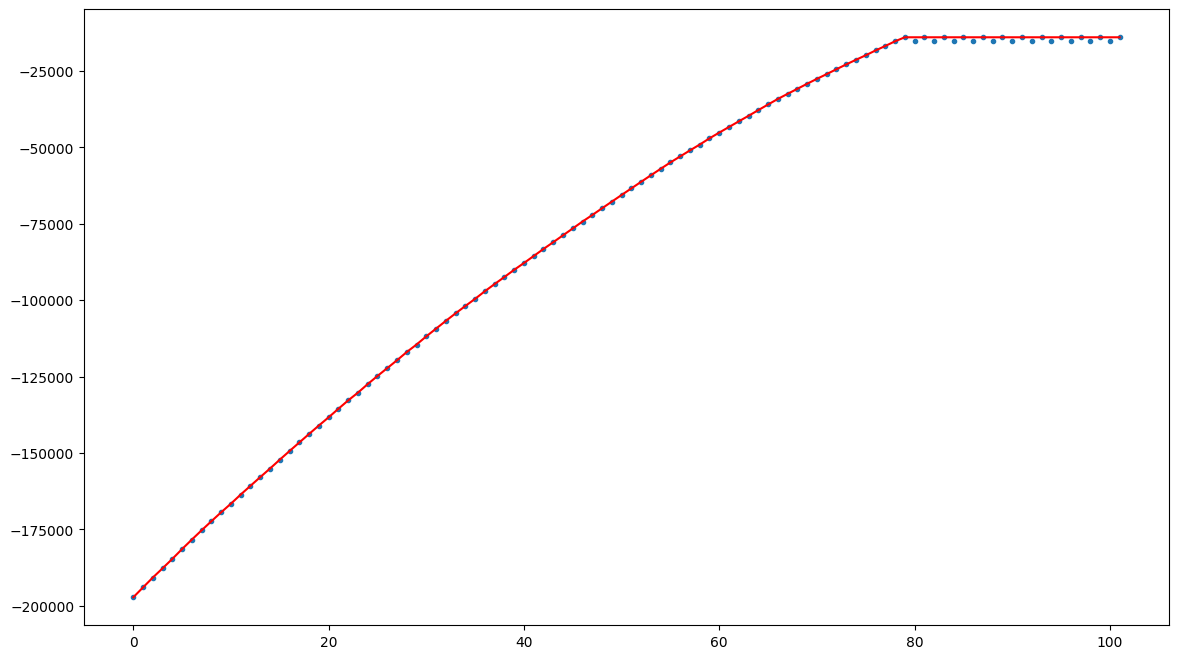

In [226]:
# Starting with a random solution with random 50% of the sets
random_solution: NDArray[np.bool] = rng.random(NUM_SETS) < 0.5
ic(fitness(random_solution), cost(random_solution), valid(random_solution))

penalty: dict[str, float] = {
    "redundancy": 5.26,
    "set_count": 0.0,
}

solution: NDArray[np.bool] = fit(random_solution, steps=100, penalty=penalty, plot=True)
ic(fitness(solution), cost(solution), valid(solution))

## Hyperspace tuning
**Attention**:

The following code require a lot of time to complete, it iterates for different value of redundancy and number of sets used penalties to find the best combination to use.

Below I put the output for the top 5 results so that there is no need to run it again, but keep in mind that the following combination is the (maybe) best for this setup of the problem:
```python
UNIVERSE_SIZE = 1_000
NUM_SETS = 200
DENSITY = 0.3
```
> e.g. changing the density may require a redundancy penalty overhaul

Other configuration of the problem may require other kind of parameters

### ⚠️Run at your own risk⚠️
#### Time to process 20m 34s for my 5 years old laptop
```python
Rank 1: Fitness = -7868.5356, Cost = 6863.8514, Redundancy Weight = 0.00, Set Count Weight = 5.26
Rank 2: Fitness = -8486.5815, Cost = 7297.7394, Redundancy Weight = 0.00, Set Count Weight = 15.79
Rank 3: Fitness = -8528.7557, Cost = 6925.5978, Redundancy Weight = 0.00, Set Count Weight = 47.37
Rank 4: Fitness = -8640.6400, Cost = 7376.8505, Redundancy Weight = 0.00, Set Count Weight = 21.05
Rank 5: Fitness = -8700.6207, Cost = 6449.2229, Redundancy Weight = 0.67, Set Count Weight = 0.00
```

In [ ]:
# Define weights to test for redundancy and set count
redundancy_weights = np.linspace(0, 3, 10)  # Adjust as needed
set_count_weights = np.linspace(0, 100, 20)  # Adjust as needed

top_solutions = []

# Nested loops to test each combination of redundancy and set count weights
for redundancy_weight in tqdm(redundancy_weights, desc="Testing Redundancy Weights"):
    for set_count_weight in tqdm(set_count_weights, desc="Testing Set Count Weights", leave=False):
        # Initialize a random solution
        solution = np.random.random(NUM_SETS) < 0.5  
        
        # Create a penalty dictionary for the current weights
        penalty = {
            "redundancy": redundancy_weight,
            "set_count": set_count_weight
        }
        
        # Run the fit function with the current weights
        final_solution = fit(solution, steps=200, penalty=penalty)
        
        # Calculate fitness and cost
        solution_fitness = fitness(final_solution, penalty)
        solution_cost = cost(final_solution)
        
        # Store the fitness and cost metrics
        top_solutions.append((solution_fitness, solution_cost, redundancy_weight, set_count_weight))


# Sort solutions by fitness (descending order)
top_solutions = sorted(top_solutions, key=lambda x: x[0], reverse=True)

# Retrieve the top 5 solutions
top_5_solutions = top_solutions[:5]

# Display top 5 weights and their corresponding fitness
for i, (fitness_val, cost_val, redundancy_weight, set_count_weight) in enumerate(top_5_solutions, start=1):
    print(f"Rank {i}: Fitness = {fitness_val:.4f}, Cost = {cost_val:.4f}, Redundancy Weight = {redundancy_weight:.2f}, Set Count Weight = {set_count_weight:.2f}")